### colab

In [1]:
import os
colab = os.getcwd() == "/content"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


### import

In [4]:
if colab:
    try:
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        import dolfinx

--2025-04-10 08:41:43--  https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4339 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.24K  --.-KB/s    in 0s      

2025-04-10 08:41:44 (39.3 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4339/4339]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/eac7ddef/release

In [5]:
if colab:
    try:
        import gmsh
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
        import gmsh

--2025-04-10 08:43:16--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0s      

2025-04-10 08:43:16 (30.3 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/543602d8/releases/h5py-install.sh
+ [[ https://gith

In [6]:
# !mpirun --allow-run-as-root --map-by slot:OVERSUBSCRIBE -np 4 python3 ns_dolfinx.py


In [7]:
from __future__ import print_function


In [8]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import copy
import tqdm.autonotebook
if colab:
    import gmsh

    from mpi4py import MPI
    from petsc4py import PETSc

    from basix.ufl import element

    from dolfinx.fem import (
        Constant,
        Function,
        functionspace,
        assemble_scalar,
        dirichletbc,
        form,
        locate_dofs_topological,
        set_bc,
    )
    from dolfinx.fem.petsc import (
        apply_lifting,
        assemble_matrix,
        assemble_vector,
        create_vector,
        create_matrix,
        set_bc,
    )
    from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
    from dolfinx.io import VTXWriter, gmshio
    from ufl import (
        FacetNormal,
        Measure,
        TestFunction,
        TrialFunction,
        as_vector,
        div,
        dot,
        dx,
        inner,
        lhs,
        grad,
        nabla_grad,
        rhs,
    )

    gmsh.initialize()

  import tqdm.autonotebook



In [9]:
from IPython.display import clear_output as clc

plt.style.use("default")


In [10]:
if colab:
    import ufl
    from basix.ufl import element, mixed_element
    from dolfinx import fem, la
    from dolfinx.fem import (Constant, Function, dirichletbc,
                            extract_function_spaces, form, functionspace,
                            locate_dofs_topological)
    from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
    from dolfinx.io import XDMFFile
    from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
    from ufl import div, dx, grad, inner
    from ufl import CellDiameter, sqrt, FacetArea

In [11]:
from scipy.interpolate import RBFInterpolator

In [12]:
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [13]:
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

In [14]:
def scatter_array(arr, label = "label", leg = False, zoom = 1, dpi = 100, s = 1):
    plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s)
    # plt.scatter(new_control_points_coords[:, 0], new_control_points_coords[:, 1], c = "b", label = "new control pts")

    add_zoom(zoom, dpi = dpi)
    plt.gca().set_aspect("equal")
    plt.gca().set_adjustable("box")

    if leg:
        plt.gca().legend(loc = "upper right")
    # plt.show()

In [15]:
if colab:
    os.chdir("/content/drive/MyDrive/my_SHRED-ROM")

# Parameters

In [16]:
L = 10
H = 4
# N_points = 121  # numero di punti per la discretizzazione dell'airfoil
chord = 1

# Airfoil parameters
chord = 1  # Adjust as needed
Aoa = 20
N_points = 121
# c_x, c_y = 0.2 * L + 0.5 * chord, H / 2
x_le, y_le = 0.3 * L, 0.5 * H

mesh_comm = MPI.COMM_WORLD
model_rank = 0
gdim = 2

# Physical and discretization parameters
t = 0
T = 10 # Final time
dt = 0.05  # Time step size
timesteps = int(T / dt)
mu_ = 0.01
rho_ = 1
U_max = 1.5
Re = (U_max * 2 / 3) * chord * rho_ / mu_
print(f"Re: {Re:.2f}")

save_numpy_unsteady = True
save_to_np_every_steps = 1
# save_to_torch_every_steps = 1
save_to_np_every_steps = 1

Re: 100.00


# Mesh generation

In [17]:
# # Mesh parameters
# # res_min = 0.001 # minima grandezza elementi vicino bordo ostacolo
# res_min = 0.01
# LcMin = res_min
# LcMax = 0.05 * H # massima grandezza elementi vicino bordi della mesh
# # LcMax = 0.1 * H
# DistMin = res_min * 3 # distanza dall'ostacolo in cui inizia il grading
# DistMax = H # distanza dall'ostacolo in cui finisce il grading

# # altre modifiche in generating the mesh
# # res_min_wake = 0.005
# res_min_wake = 0.05
# LcMax_wake = 0.05 * H
# DistMin_wake = res_min_wake * 3
# DistMax_wake = H

# Fine mesh
# generate_fine_mesh = True
# write_fine_mesh = False
# save_fine_mesh_numpy = True

# lref = f"cl{chord}_Aoa{Aoa}"
# name = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}_Re{Re}"
# name_unsteady = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}_Re{Re}_dt{dt}"
# name_mesh = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}"
# write_mesh = False
# save_mesh_numpy = True
# write_stokes = False
# write_ns = False
# write_ns_unsteady = False
# save_numpy = False

In [18]:
# airfoil_coords = generate_airfoil(0, 0.4, 0.12, N_points) # NACA 0012
# # mesh = generate_airfoil_mesh(base_pts, L, H, ref = 128)

# ntrajectories = 1
# nparams = 2 + 11 # physical + airfoil

In [19]:
# x_airfoil, y_airfoil = (airfoil_coords[:, 0] + x_le).tolist(), (airfoil_coords[:, 1] + y_le).tolist()

In [20]:
# # if mesh_comm.rank == model_rank:
#     # Create rectangle domain
# rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)

In [21]:
# points = []
# for i in range(len(x_airfoil)):
#     point = gmsh.model.occ.addPoint(x_airfoil[i], y_airfoil[i], 0)
#     points.append(point)
# points.append(points[0])
# spline = gmsh.model.occ.addSpline(points)
# # line_last_first = gmsh.model.occ.addLine(points[-1], points[0])
# # airfoil_curve = gmsh.model.occ.addCurveLoop([spline, line_last_first])
# airfoil_curve = gmsh.model.occ.addCurveLoop([spline])
# obstacle = gmsh.model.occ.addPlaneSurface([airfoil_curve])

In [22]:
# p1 = gmsh.model.occ.addPoint(x_le + chord + 0.01, y_le, 0)
# p2 = gmsh.model.occ.addPoint(L, H / 2, 0)
# horizontal_line = gmsh.model.occ.addLine(p1, p2)
# gmsh.model.occ.synchronize()

In [23]:
# fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
# gmsh.model.occ.synchronize()

In [24]:
# fluid_marker = 1
# # if mesh_comm.rank == model_rank:
# # Add physical volume marker
# volumes = gmsh.model.getEntities(dim=gdim)
# assert len(volumes) == 1
# gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
# gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

In [25]:
# inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
# inflow, outflow, walls, obstacle = [], [], [], []
# # if mesh_comm.rank == model_rank:
# boundaries = gmsh.model.getBoundary(volumes, oriented=False)
# for boundary in boundaries:
#     center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
#     if np.allclose(center_of_mass, [0, H / 2, 0]):
#         inflow.append(boundary[1])
#     elif np.allclose(center_of_mass, [L, H / 2, 0]):
#         outflow.append(boundary[1])
#     elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(
#         center_of_mass, [L / 2, 0, 0]
#     ):
#         walls.append(boundary[1])
#     else:
#         obstacle.append(boundary[1])
# gmsh.model.addPhysicalGroup(1, walls, wall_marker)
# gmsh.model.setPhysicalName(1, wall_marker, "Walls")
# gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
# gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
# gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
# gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
# gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
# gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In [26]:
# # res_min = 0.001
# # if mesh_comm.rank == model_rank:

# # Mesh Refinement con transfinite e grading
# distance_field = gmsh.model.mesh.field.add("Distance")
# gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)

# grading_field = gmsh.model.mesh.field.add("Threshold")
# gmsh.model.mesh.field.setNumber(grading_field, "IField", distance_field)
# gmsh.model.mesh.field.setNumber(grading_field, "LcMin", res_min)
# gmsh.model.mesh.field.setNumber(grading_field, "LcMax", LcMax)
# gmsh.model.mesh.field.setNumber(grading_field, "DistMin", DistMin)
# gmsh.model.mesh.field.setNumber(grading_field, "DistMax", DistMax)
# # final_field = gmsh.model.mesh.field.add("Min")
# # gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field])
# # gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

# # Wake refinement
# horizontal_line_field = gmsh.model.mesh.field.add("Distance")
# gmsh.model.mesh.field.setNumbers(horizontal_line_field, "EdgesList", [horizontal_line])
# horizontal_refine_field = gmsh.model.mesh.field.add("Threshold")
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "IField", horizontal_line_field)
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMin", res_min_wake)  # dimensione minima vicino alla linea
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMax", LcMax_wake)    # dimensione massima lontano dalla linea
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMin", DistMin_wake)  # distanza entro cui applicare LcMin
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMax", DistMax_wake)  # distanza oltre cui applicare LcMax

# final_field = gmsh.model.mesh.field.add("Min")
# gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field, horizontal_refine_field])
# gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

# # Impostazioni avanzate per la mesh
# gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay
# # gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)  # Quadrangolazione
# gmsh.option.setNumber("Mesh.RecombineAll", 0)
# # gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 2)  # Maggiore regolarità

# # Generazione e ottimizzazione
# gmsh.model.mesh.generate(gdim)
# gmsh.model.mesh.setOrder(1)
# # gmsh.model.mesh.optimize("HighOrder")

# # Salva la mesh
# # gmsh.write("airfoil_mesh.msh")
# # gmsh.finalize()

In [27]:
# # if mesh_comm.rank == model_rank:
# quality = gmsh.model.mesh.getNodes()
# print(f"Generated {len(quality[0])} nodes.")


In [28]:
# mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
# ft = facet_tags
# ft.name = "Facet markers"
# cell_tags.name = "Cell markers"

In [29]:
# # # Get mesh topology and geometry
# topology, cell_types, geometry = dolfinx.plot.vtk_mesh(mesh, mesh.topology.dim)

In [30]:
# with dolfinx.io.XDMFFile(mesh.comm, "mesh.xdmf", "w") as xdmf:
#     xdmf.write_mesh(mesh)
#     xdmf.write_meshtags(ft, mesh.geometry)


In [31]:
# gmsh.write("naca0012_mesh.msh")

# Utilities

In [32]:
def generate_airfoil(m=0.02, p=0.4, t=0.12, n_points=100, x_le = 0.0, y_le = 0.0):
    """
    Genera un profilo alare tipo NACA-like con parametri semplificati.

    Args:
        m: massimo camber (es. 0.02 = 2%)
        p: posizione del camber (0-1, frazione della corda)
        t: spessore massimo (es. 0.12 = 12%)
        n_points: numero di punti (metà superiore)

    Returns:
        x: array di coordinate x
        y_upper: array dell’estradosso
        y_lower: array dell’intradosso
    """

    # x = np.linspace(0, 1, n_points)
    x = (1 - np.cos(np.linspace(0, 1, int(np.ceil(n_points/2)))*np.pi)) / 2

    # Curva camber
    yc = np.where(x < p,
                  m / p**2 * (2*p*x - x**2),
                  m / (1 - p)**2 * ((1 - 2*p) + 2*p*x - x**2))

    # Derivata del camber
    dyc_dx = np.where(x < p,
                      2*m / p**2 * (p - x),
                      2*m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Spessore (classica formula NACA 4-digit)
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

    # Coordinate superiori e inferiori
    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Unione dei punti per profilo completo
    x_coords = np.concatenate([x_upper[::-1], x_lower[1:]])
    y_coords = np.concatenate([y_upper[::-1], y_lower[1:]])

    return np.concatenate((x_coords.reshape(-1,1) + x_le, y_coords.reshape(-1,1) + y_le), axis = 1)

def generate_airfoil_random(chord = 1, n_points=100, x_le = 0.0, y_le = 0.0):
    m = np.random.rand() * 0.05 * chord
    p = (np.random.rand() * 0.3 + 0.3) * chord
    t = (np.random.rand() * 0.06 + 0.09) * chord

    return generate_airfoil(m, p, t, n_points, x_le, y_le)


In [33]:
from matplotlib import pyplot as plt
import matplotlib.tri as tri
import numpy as np

def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    return ordered_points

def point_in_obstacle(xy_points, xy_obstacle):
    """
    Determine if points are inside the NACA 0012 airfoil using JAX.
    """
    xy_points = np.array(xy_points, dtype=np.float32)
    ordered_xy_obstacle = order_polygon(xy_obstacle)
    obstacle_x, obstacle_y = ordered_xy_obstacle[:, 0], ordered_xy_obstacle[:, 1]

    x_pts = xy_points[:, 0]
    y_pts = xy_points[:, 1]

    # Roll the obstacle boundary to get pairs of consecutive points
    x1, y1 = obstacle_x, obstacle_y
    x2, y2 = np.roll(obstacle_x, shift=-1, axis=0), np.roll(obstacle_y, shift=-1, axis=0)

    # Conditions for ray intersection with edges
    intersects = np.logical_and(
        np.logical_or(y1 <= y_pts[:, None], y2 <= y_pts[:, None]),
        np.logical_or(y1 > y_pts[:, None], y2 > y_pts[:, None]),
    )

    # Compute intersection x-coordinates using vectorized form
    denom = (y2 - y1) + 1e-9  # Avoid division by zero
    x_intersect = x1 + (y_pts[:, None] - y1) * (x2 - x1) / denom

    # Check if x-coordinates of the intersection are greater than x_pts
    inside = np.sum(
        np.where(np.logical_and(intersects, x_pts[:, None] < x_intersect), 1, 0), axis=1
    )

    # If count of intersections is odd, point is inside
    return inside % 2 == 1

In [34]:
def norm_L2(comm, v):
    """Compute the L2(Ω)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(inner(v, v) * dx)), op=MPI.SUM))


In [35]:
from dolfinx import default_real_type

def domain_average(msh, v):
    """Compute the average of a function over the domain"""
    vol = msh.comm.allreduce(fem.assemble_scalar(fem.form(fem.Constant(msh, default_real_type(1.0)) * dx)), op=MPI.SUM)
    return (1 / vol) * msh.comm.allreduce(fem.assemble_scalar(fem.form(v * dx)), op=MPI.SUM)


In [36]:
def get_markers_and_nodes():
    markers = [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker] = [1, 2, 3, 4, 5]
    lists = [[], [], [], [], []]
    for node_list, marker in list(zip(lists, markers)):
        node_tags, node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, marker)

        for i, tag in enumerate(node_tags):
            x = node_coords[3 * i]       # coordinata x
            y = node_coords[3 * i + 1]   # coordinata y
            node_list.append([x, y])

    return  markers, lists[1:]

In [37]:
def interpolate_mesh(mesh, control_points, displacements):
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    Q = functionspace(mesh, s_cg1)
    mesh_coords = np.array(Q.tabulate_dof_coordinates())

    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(mesh_coords[:, :2])
    mesh.geometry.x[:, :2] = mesh_coords[:, :2] + displacements

    return mesh

In [38]:
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [39]:
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05):

    N_points = airfoil_coords.shape[0]
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
    wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

    control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
    displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)

    return control_points, displacements


In [40]:
class InletVelocity:
    def __init__(self, U_max, alpha):
        # self.t = t
        self.U_max = U_max
        self.alpha = alpha

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # U_max * np.sin(self.t * np.pi / 8)
            U_max * np.cos(self.alpha)
        )
        values[1] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # 4 * U_max * x[1] * (H - x[1]) / (H**2)
            4 * self.U_max * x[1] * (H - x[1]) / (H**2) * np.sin(self.alpha)
        )
        return values

def get_bcs(mesh, V, Q, ft, U_max, alpha):

    fdim = mesh.topology.dim - 1

    # Define boundary conditions
    # Inlet
    u_inlet = Function(V)
    inlet_velocity = InletVelocity(U_max, alpha)
    u_inlet.interpolate(inlet_velocity)
    bcu_inflow = dirichletbc(
        u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker))
    )

    # Walls
    # # nonslip
    u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    # bcu_walls = dirichletbc(
    #     u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V
    # )
    # freeslip
    walls_dofs_y = locate_dofs_topological(V.sub(1), mesh.topology.dim - 1, ft.find(wall_marker))
    bcu_walls = dirichletbc(dolfinx.default_scalar_type(0), walls_dofs_y, V.sub(1))

    # Obstacle
    bcu_obstacle = dirichletbc(
        u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V
    )
    bcu = [bcu_inflow, bcu_obstacle, bcu_walls]

    # Outlet
    bcp_outlet = dirichletbc(
        PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q
    )
    bcp = [bcp_outlet]

    return bcu, bcp, u_inlet, inlet_velocity

In [41]:
from ufl import CellDiameter, sqrt, FacetArea

In [42]:
def solve(params, mesh, facet_tags, dt, num_steps, mu_, rho_, save_to_np_every_steps = 10):

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim,))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)

    # Spazi su cui proiettare U e p
    elem_vectorial =  element("Lagrange", mesh.topology.cell_name(), 1, shape=(mesh.geometry.dim,))
    Q_vectorial = functionspace(mesh, elem_vectorial) # per salvare u sui nodi di p (di grado 1)

    u = TrialFunction(V)
    v = TestFunction(V)
    u_ = Function(V)
    u_.name = "u"
    u_s = Function(V)
    u_n = Function(V)
    u_n1 = Function(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    p_ = Function(Q)
    p_.name = "p"
    phi = Function(Q)

    U_max_0 = params[1][0]
    alpha_0 = params[0][0]
    bcu, bcp, u_inlet, inlet_velocity = get_bcs(mesh, V, Q, facet_tags, U_max_0, alpha_0)

    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(mu_))  # Dynamic viscosity
    rho = Constant(mesh, PETSc.ScalarType(rho_))  # Density

    # # Create a DG0 space (discontinuous elements, one value per cell)
    # element_dg0 = element("DG", mesh.topology.cell_name(), 0)
    # DG0 = functionspace(mesh, element_dg0)
    # h_func = Function(DG0)

    # # Manually compute an approximation of cell size
    # # Create a function to estimate diameter based on cell geometry
    # def estimate_cell_diameters(mesh):
    #     tdim = mesh.topology.dim
    #     num_cells = mesh.topology.index_map(tdim).size_local
    #     h_approx = np.ones(num_cells)

    #     # For each cell, we'll use the average edge length as an estimate
    #     mesh.topology.create_connectivity(tdim, 1)  # Create cell-edge connectivity
    #     mesh.topology.create_connectivity(1, 0)     # Create edge-vertex connectivity

    #     cell_to_edges = mesh.topology.connectivity(tdim, 1)
    #     edge_to_vertices = mesh.topology.connectivity(1, 0)

    #     # Get geometry
    #     x = mesh.geometry.x

    #     # Compute for each cell
    #     for i in range(num_cells):
    #         edges = cell_to_edges.links(i)
    #         avg_length = 0.0
    #         for e in edges:
    #             vertices = edge_to_vertices.links(e)
    #             p0, p1 = x[vertices[0]], x[vertices[1]]
    #             edge_length = np.linalg.norm(p1 - p0)
    #             avg_length += edge_length

    #         h_approx[i] = avg_length / len(edges) if len(edges) > 0 else 1.0

    #     return h_approx

    # # Compute approximate cell diameters
    # h_values = estimate_cell_diameters(mesh)
    # h_func.x.array[:] = h_values

    # # Use h_func in your calculations
    # h = h_func

    # # Redefine tau_supg using h_func
    # vnorm = sqrt(dot(u_n, u_n) + 1e-10)  # Avoid division by zero
    # tau_supg = h / (2 * vnorm / dt + 4 * mu / (rho * h**2))

    # Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts.
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    F1 = rho / k * dot(u - u_n, v) * dx
    F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
    F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
    F1 += dot(f, v) * dx
    # residual_momentum = (
    #     rho / k * (u - u_n)
    #     + dot(1.5 * u_n - 0.5 * u_n1, nabla_grad(u))
    #     - div(mu * grad(u)) + grad(p_)
    # )

    # F1_SUPG = F1 + tau_supg * dot(residual_momentum, v) * dx
    # a1 = form(lhs(F1_SUPG))
    # L1 = form(rhs(F1_SUPG))
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    A1 = create_matrix(a1)
    b1 = create_vector(L1)

    a2 = form(dot(grad(p), grad(q)) * dx)
    L2 = form(-rho / k * dot(div(u_s), q) * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)

    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)

    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.LU)
    pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver
    solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))

    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.LU)
    pc2.setFactorSolverType("mumps")
    solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))

    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.LU)
    pc3.setFactorSolverType("mumps")
    solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

    # Eseguire prima set up initial set up in steady problem
    u_ns_unsteady = Function(Q_vectorial)
    u_ns_unsteady.interpolate(u_)
    # newshape_ = (u_ns_unsteady.x.array[:].shape[0]//2, 2)
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, newshape = newshape_))
    U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))

    u_np = np.zeros_like(U[:, 0].reshape(1, -1))
    v_np = np.zeros_like(U[:, 1].reshape(1, -1))
    p_np = np.zeros_like(p_.x.array).reshape(1, -1)
    # u_mag_np = np.sqrt(u_np**2 + v_np**2)

    # u_torch = torch.zeros_like(U[:, 0]).reshape(1, -1)
    # v_torch = torch.zeros_like(U[:, 1]).reshape(1, -1)
    # p_torch = torch.zeros_like(torch.tensor(p_.x.array)).reshape(1, -1)

    progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

    t = 0
    for i in range(num_steps):

        progress.update(1)

        # Update current time step
        t += dt

        L2norm_u = np.sqrt(mesh_comm.allreduce(assemble_scalar(form((u_)**2 * dx)), MPI.SUM))
        L2norm_p = np.sqrt(mesh_comm.allreduce(assemble_scalar(form((p_)**2 * dx)), MPI.SUM))

        print(f"timestep {i+1}, time {t}",
              ", ||u||_L2 = ", L2norm_u,
              ", ||p||_L2 = ", L2norm_p
              )

        if L2norm_u > 1000:
            print("Crashed.")
            return u_np, v_np, p_np

        # Update inlet velocity
        # inlet_velocity.t = t
        inlet_velocity.U_max = params[1][i]
        inlet_velocity.alpha = params[0][i]
        u_inlet.interpolate(inlet_velocity)

        A1.zeroEntries()
        assemble_matrix(A1, a1, bcs=bcu)
        A1.assemble()
        with b1.localForm() as loc:
            loc.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_s.x.petsc_vec)
        u_s.x.scatter_forward()

        # Step 2: Pressure corrrection step
        with b2.localForm() as loc:
            loc.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, phi.x.petsc_vec)
        phi.x.scatter_forward()

        p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
        p_.x.scatter_forward()

        # Step 3: Velocity correction step
        with b3.localForm() as loc:
            loc.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()

        # clc(wait = True)

        # if save_numpy_unsteady:
        if i % save_to_np_every_steps == 0:
            # Save to np
            u_ns_unsteady.interpolate(u_)
            U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
            u_np = np.concatenate((u_np, U[:, 0].reshape(1, -1)), 0)
            v_np = np.concatenate((v_np, U[:, 1].reshape(1, -1)), 0)
            p_np = np.concatenate((p_np, p_.x.array.reshape(1, -1)), 0)
            # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # if i % save_to_torch_every_steps == 0:
        #     # Save to np
        #     u_ns_unsteady.interpolate(u_)
        #     U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))
        #     u_torch = torch.cat((u_torch, U[:, 0].reshape(1, -1)), 0)
        #     v_torch = torch.cat((v_torch, U[:, 1].reshape(1, -1)), 0)
        #     p_torch = torch.cat((p_torch, torch.tensor(p_.x.array.reshape(1, -1))), 0)
        #     # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # Update variable with solution form this time step
        with (
            u_.x.petsc_vec.localForm() as loc_,
            u_n.x.petsc_vec.localForm() as loc_n,
            u_n1.x.petsc_vec.localForm() as loc_n1,
        ):
            loc_n.copy(loc_n1)
            loc_.copy(loc_n)

    progress.close()
    # return u_torch, v_torch, p_torch
    return u_np, v_np, p_np


# Snapshots generation

### Load NACA0012 mesh

In [ ]:
if colab:
    os.chdir("/content/drive/MyDrive/my_SHRED-ROM")

In [ ]:
# Load naca0012 mesh
gmsh.initialize()
gmsh.open("naca0012_mesh.msh")

mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=gdim)
ft = facet_tags
[fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker], [inlet_nodes, outlet_nodes, wall_nodes, obstacle_nodes] = get_markers_and_nodes()
airfoil_coords = np.array(obstacle_nodes)
N_points = airfoil_coords.shape[0]

# if mesh_comm.rank == model_rank:
quality = gmsh.model.mesh.getNodes()
print(f"Mesh has {len(quality[0])} nodes.")

Mesh has 14472 nodes.


In [ ]:
gmsh.finalize()

In [ ]:
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
naca0012_coords = np.array(functionspace(mesh, s_cg1).tabulate_dof_coordinates())
naca0012_airfoil_coords = copy.deepcopy(airfoil_coords)

In [ ]:
# np.savez("naca0012_data.npz", naca0012_coords = naca0012_coords, naca0012_airfoil_coords = naca0012_airfoil_coords)

In [ ]:
# naca0012_data = np.load("naca0012_data.npz")
# naca0012_coords = naca0012_data['naca0012_coords']
# naca0012_airfoil_coords = naca0012_data['naca0012_airfoil_coords']

 ### Single snapshot

In [ ]:
# params_ph_range = [(-1.0, 1.0), (0.5, 2), ] # Physical parameters: angle of attack and inflow intensity
# params_airfoil_range = [(0.0, 0.05 * chord), (0.3 * chord, 0.6 * chord), (0.09 * chord, 0.15 * chord)] # Airfoil parameters: max camber, camber position, max thickness
# params_range = params_ph_range + params_airfoil_range

# # U = np.zeros((ntrajectories, ntimes, npressure))
# # V = np.zeros((ntrajectories, ntimes, npressure))
# # P = np.zeros((ntrajectories, ntimes, npressure))
# # MU = np.zeros((ntrajectories, ntimes, nparams))

# airfoil_indices_list = []

# # os.makedirs("snapshots", exist_ok=True)

# for i in range(ntrajectories):

#     print(f"Generating snapshot n.{i}...")

#     params = [0] * len(params_range)
#     for j in range(len(params_range)):
#         params[j] = ((params_range[j][1] - params_range[j][0]) * np.random.rand(1) + params_range[j][0]).item()
#     params = [[param_i] * ntimes for param_i in params] # shape (n_params, n_timesteps)

#     m_ = params[2][0]
#     p_ = params[3][0]
#     t_ = params[4][0]
#     new_pts = generate_airfoil(m_, p_, t_, N_points)

#     print("U_max : ", params[1][0], " [m/s]")
#     print("Aoa : ", params[0][0] * 180 / np.pi, " deg")
#     print("Re: ", params[1][0] * np.cos(params[0][0]) * chord  * rho_ / mu_)

#     # Interpolate mesh on new airfoil
#     # new_airfoil_coords = generate_airfoil(m_, p_, t_, n_points = N_points, x_le = x_le, y_le = y_le)
#     # control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     # mesh = interpolate_mesh(mesh, control_points, displacements)
#     # airfoil_coords = new_airfoil_coords

#     [u, v, p] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_np_every_steps)

#     U[i] = u_np
#     V[i] = v_np
#     P[i] = p_np

#     for j, param_j in enumerate(params, 0):
#         MU[i, :, j] = np.array(param_j)

#     clc(wait = True)

#     np.savez(f"snapshots/snapshot_{i}.npz", u_np = u_np, v_np = v_np, p_np = p_np, params = params)

# print("Snapshots generated!")

# period = 10
# phase = np.pi
# U_max = 2
# # alpha = 1

# angles = [np.cos(2*np.pi*float(dt)*j/period + phase) for j in range(timesteps)]
# params = [angles, [U_max] * timesteps]

# print("U_max : ", params[1][0], " [m/s]")
# # print("Aoa : ", params[0][0] * 180 / np.pi, " deg")
# print(f"Aoa : between {(max(angles)) * 180 / np.pi} and {(min(angles)) * 180 / np.pi} deg")
# # print("Max Re: ", params[1][0] * np.cos(params[0][0]) * chord  * rho_ / mu_)
# print("Max Re: ", params[1][0] * chord  * rho_ / mu_)

# [u, v, p] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_np_every_steps)

### Snapshots loop: constant parameters

In [ ]:
# ntrajectories = 100
# nparams = 2 + 3 # physical + airfoil
# # nvelocity = VectorFunctionSpace(mesh, "CG", 2).dim()
# npressure = mesh.geometry.x.shape[0]
# ntimes = timesteps + 1 # initial condition

In [ ]:
# params_ph_range = [(-1.0, 1.0), (0.5, 2), ] # Physical parameters: angle of attack and inflow intensity
# params_airfoil_range = [(0.0, 0.05 * chord), (0.3 * chord, 0.6 * chord), (0.09 * chord, 0.15 * chord)] # Airfoil parameters: max camber, camber position, max thickness
# params_range = params_ph_range + params_airfoil_range

# filename = 'FlowAroundAirfoil_data'
# # U = torch.zeros(ntrajectories, ntimes, npressure)
# # V = torch.zeros(ntrajectories, ntimes, npressure)
# # P = torch.zeros(ntrajectories, ntimes, npressure)
# # MU = torch.zeros(ntrajectories, ntimes, nparams)

# U = np.zeros((ntrajectories, ntimes, npressure))
# V = np.zeros((ntrajectories, ntimes, npressure))
# P = np.zeros((ntrajectories, ntimes, npressure))
# MU = np.zeros((ntrajectories, ntimes, nparams))

# airfoil_indices_list = []

# os.makedirs("snapshots", exist_ok=True)

# for i in range(ntrajectories):

#     print(f"Generating snapshot n.{i}...")

#     params = [0] * len(params_range)
#     for j in range(len(params_range)):
#         params[j] = ((params_range[j][1] - params_range[j][0]) * np.random.rand(1) + params_range[j][0]).item()
#     params = [[param_i] * ntimes for param_i in params] # shape (n_params, n_timesteps)

#     m_ = params[2][0]
#     p_ = params[3][0]
#     t_ = params[4][0]
#     new_pts = generate_airfoil(m_, p_, t_, N_points)

#     print("U_max : ", params[1][0], " [m/s]")
#     print("Aoa : ", params[0][0] * 180 / np.pi, " deg")
#     print("Re: ", params[1][0] * np.cos(params[0][0]) * chord  * rho_ / mu_)

#     # Interpolate mesh on new airfoil
#     new_airfoil_coords = generate_airfoil(m_, p_, t_, n_points = N_points, x_le = x_le, y_le = y_le)
#     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     mesh = interpolate_mesh(mesh, control_points, displacements)
#     airfoil_coords = new_airfoil_coords

#     # [ut, vt, pt] = compute_state(params, mesh, dt, nu, ntimesteps)
#     # [ut, vt, pt] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_torch_every_steps)
#     [u_np, v_np, p_np] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_np_every_steps)

#     # U[i] = ut
#     # V[i] = vt
#     # P[i] = pt

#     U[i] = u_np
#     V[i] = v_np
#     P[i] = p_np

#     # for j, param_j in enumerate(params, 0):
#     #     MU[i, :, j] = torch.tensor(param_j)

#     for j, param_j in enumerate(params, 0):
#         MU[i, :, j] = np.array(param_j)

#     clc(wait = True)

#     # np.savez(f"snapshots/snapshot_{i}.npz", ut = ut, vt = vt, pt = pt, params = params)
#     np.savez(f"snapshots/snapshot_{i}.npz", u_np = u_np, v_np = v_np, p_np = p_np, params = params)

# print("Snapshots generated!")

# # np.savez("%s.npz" % filename.replace(".npz",""), v = V, p = P, mu = MU)

### Snapshots loop: time-dependent parameters

In [ ]:
200 - len(os.listdir("snapshots"))

22

In [ ]:
# ntrajectories =
ntrajectories = 22
nparams = 2 + 3 # physical + airfoil
# nvelocity = VectorFunctionSpace(mesh, "CG", 2).dim()
npressure = mesh.geometry.x.shape[0]
ntimes = timesteps + 1 # initial condition

In [ ]:
params_ph_range = [(2.5, 20), (0, 2*np.pi), (0.5, 2)] # Physical parameters: angle of attack and inflow intensity
params_airfoil_range = [(0.0, 0.05 * chord), (0.3 * chord, 0.6 * chord), (0.09 * chord, 0.15 * chord)] # Airfoil parameters: max camber, camber position, max thickness
params_range = params_ph_range + params_airfoil_range

filename = 'FlowAroundAirfoil_data'
# U = torch.zeros(ntrajectories, ntimes, npressure)
# V = torch.zeros(ntrajectories, ntimes, npressure)
# P = torch.zeros(ntrajectories, ntimes, npressure)
# MU = torch.zeros(ntrajectories, ntimes, nparams)

# U = np.zeros((ntrajectories, ntimes, npressure))
# V = np.zeros((ntrajectories, ntimes, npressure))
# P = np.zeros((ntrajectories, ntimes, npressure))
# MU = np.zeros((ntrajectories, ntimes, nparams))

airfoil_indices_list = []

os.makedirs("snapshots", exist_ok=True)

for i in range(200 - ntrajectories, 200):

    print(f"Generating snapshot n.{i}...")

    angle_params = [0] * 2
    for j in range(2):
        angle_params[j] = ((params_range[j][1] - params_range[j][0]) * np.random.rand(1) + params_range[j][0]).item()
    angles = [np.cos(2*np.pi*float(dt)*j/angle_params[0] + angle_params[1]) for j in range(ntimes)]

    params = [0] * (len(params_range) - 2)
    for j in range(len(params_range) - 2):
        params[j] = ((params_range[j + 2][1] - params_range[j + 2][0]) * np.random.rand(1) + params_range[j + 2][0]).item()

    params = [[param_i] * ntimes for param_i in params] # shape (n_params, n_timesteps)
    params = [angles] + params

    m_ = params[2][0]
    p_ = params[3][0]
    t_ = params[4][0]
    new_pts = generate_airfoil(m_, p_, t_, N_points)

    print("U_max : ", params[1][0], " [m/s]")
    print(f"Aoa : between {1 * 180 / np.pi} and {-1 * 180 / np.pi} deg with freq {1 / angle_params[0]} and phase {angle_params[1] * 180 / np.pi}")
    print("Max Re: ", params[1][0] * chord  * rho_ / mu_)

    # Interpolate mesh on new airfoil
    new_airfoil_coords = generate_airfoil(m_, p_, t_, n_points = N_points, x_le = x_le, y_le = y_le)
    control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
    mesh = interpolate_mesh(mesh, control_points, displacements)
    airfoil_coords = new_airfoil_coords

    # [ut, vt, pt] = compute_state(params, mesh, dt, nu, ntimesteps)
    # [ut, vt, pt] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_torch_every_steps)
    [u_np, v_np, p_np] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_np_every_steps)

    # U[i] = ut
    # V[i] = vt
    # P[i] = pt

    # U[i - 100] = u_np
    # V[i - 100] = v_np
    # P[i - 100] = p_np

    # # for j, param_j in enumerate(params, 0):
    # #     MU[i, :, j] = torch.tensor(param_j)

    # for j, param_j in enumerate(params, 0):
    #     MU[i - 100, :, j] = np.array(param_j)

    clc(wait = True)

    # np.savez(f"snapshots/snapshot_{i}.npz", ut = ut, vt = vt, pt = pt, params = params)
    np.savez(f"snapshots/snapshot_{i}.npz", u_np = u_np, v_np = v_np, p_np = p_np, params = params)

print("Snapshots generated!")

# np.savez("%s.npz" % filename.replace(".npz",""), v = V, p = P, mu = MU)

Snapshots generated!


# Plotting

In [ ]:
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [ ]:
from IPython.display import clear_output as clc

In [ ]:
import seaborn as sns
from matplotlib import colors
ice = sns.color_palette("icefire", as_cmap=True).colors
col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
col.insert(0, "black")
cmap = colors.LinearSegmentedColormap.from_list("", col)

In [ ]:
params_geo = [0.0, 0.0, 0.12]

In [ ]:
def update_coords_and_triang(params, coords = naca0012_coords, airfoil_coords = naca0012_airfoil_coords):

    if not params == [0.0, 0.0, 0.12]:
        new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
        control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
        coords = interpolate_coords(coords, control_points, displacements)
    else:
        new_airfoil_coords = airfoil_coords
    x, y = coords[:, 0], coords[:, 1]
    triang = tri.Triangulation(x, y)
    x_tri = x[triang.triangles].mean(axis=1)
    y_tri = y[triang.triangles].mean(axis=1)
    mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(new_airfoil_coords[:, 0], new_airfoil_coords[:, 1]))])
    triang.set_mask(mask)

    return coords, triang

In [ ]:
coords, triang = update_coords_and_triang(params_geo)

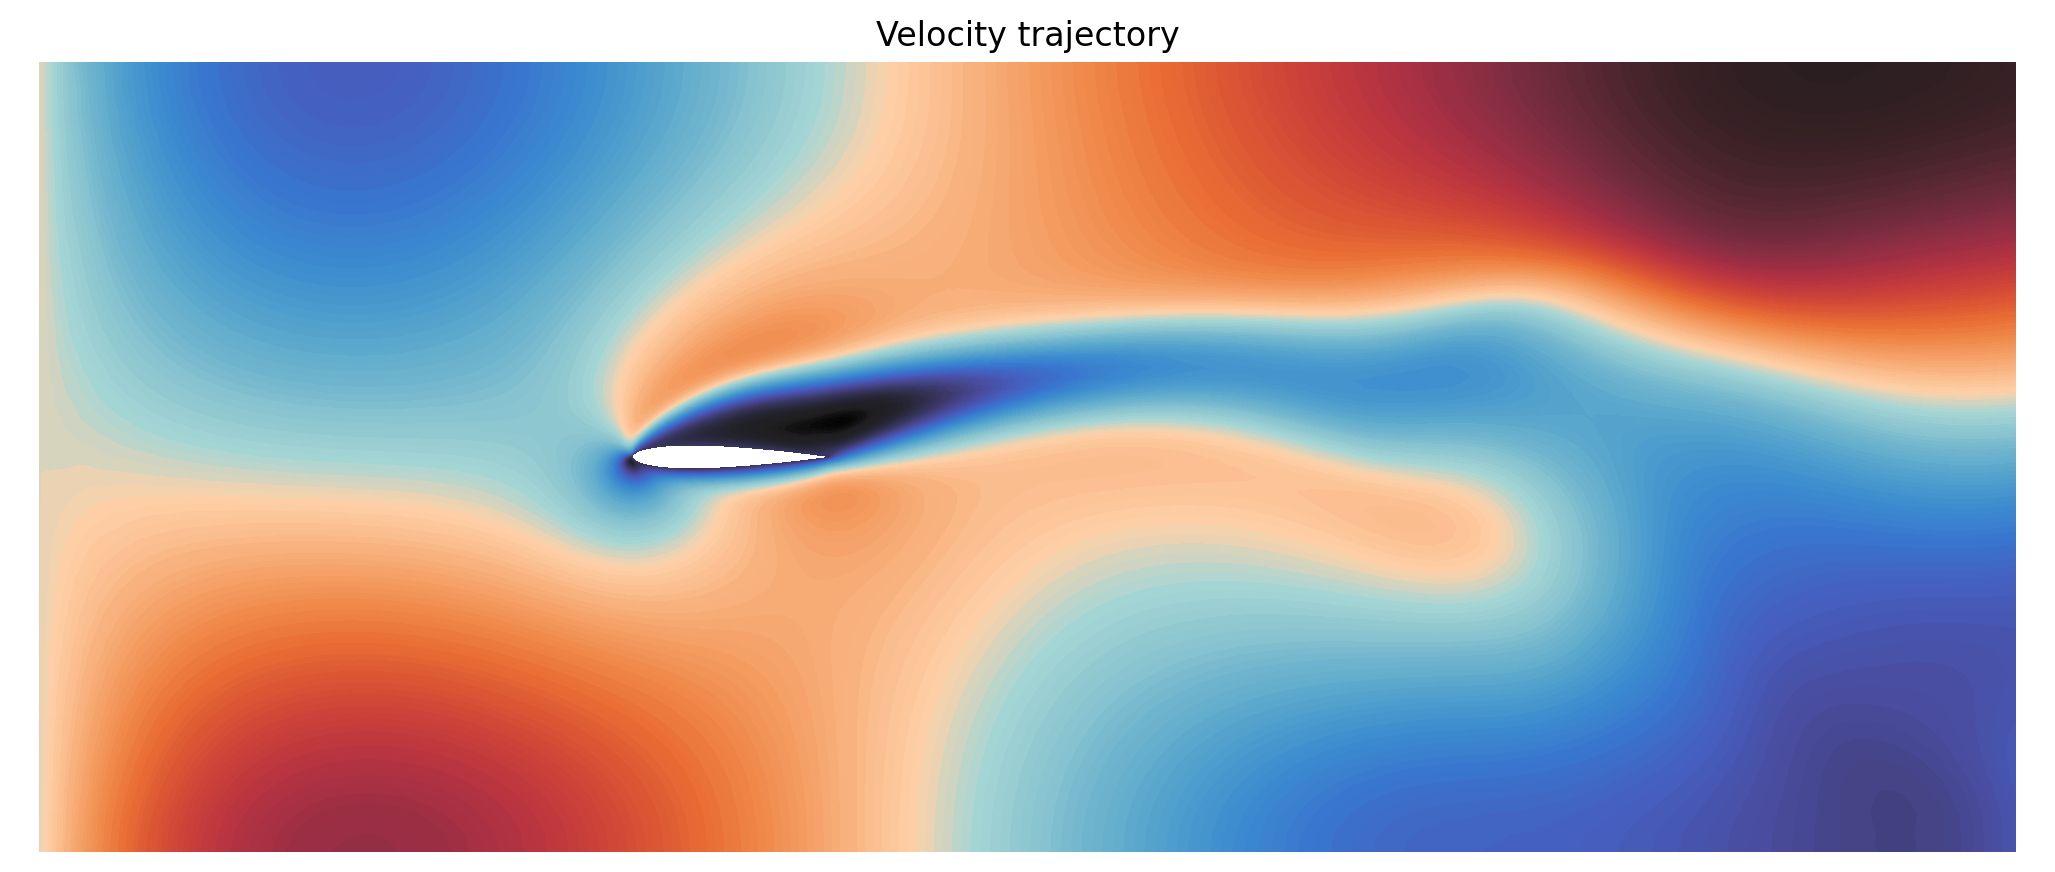

In [ ]:
def trajectory(vt, params_geo, title = None):
    """
    Trajectory
    Input: trajectory with dimension (ntimes, nvelocity) and geometric parameters
    """
    # redefine plot_v on new triang
    coords, triang = update_coords_and_triang(params_geo)
    def plot_v(v, triang = triang):
        plt.tricontourf(triang, v, cmap = cmap, levels = 200)
        plt.gca().set_aspect("equal")
        add_zoom(zoom = 1.3)

    for i in range(vt.shape[0]):
        plt.figure(figsize=(10,10))
        plot_v(vt[i])
        plt.xlim((-0.1,10.1))
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

# whichtrajectory = 40
whichtimes = np.arange(0, 200, 10)

trajectory(u[whichtimes], params_geo, title = "Velocity trajectory")

In [ ]:
v.max()

np.float64(1.9703658997824198)

# Load Snapshots

In [ ]:
# os.chdir('/content/drive/MyDrive/my_SHRED-ROM')

In [ ]:
npressure = naca0012_coords.shape[0]
nvelocity = npressure
ntimes = timesteps + 1 # initial condition
ntrajectories = len(os.listdir("snapshots"))
nparams = 5

In [ ]:
Vx = torch.zeros(ntrajectories, ntimes, npressure)
Vy = torch.zeros(ntrajectories, ntimes, npressure)
P = torch.zeros(ntrajectories, ntimes, npressure)
MU = torch.zeros(ntrajectories, ntimes, nparams)

In [ ]:
# data = np.load(f"snapshots/snapshot_0.npz")
# if "ut" in data:
#     Vx = torch.tensor(data["ut"]).unsqueeze(0)
#     Vy = torch.tensor(data["vt"]).unsqueeze(0)
#     P = torch.tensor(data["pt"]).unsqueeze(0)
# else:
#     Vx = torch.tensor(data["u_np"]).unsqueeze(0)
#     Vy = torch.tensor(data["v_np"]).unsqueeze(0)
#     P = torch.tensor(data["p_np"]).unsqueeze(0)

In [ ]:
for i in range(ntrajectories):

    print(i)

    data = np.load(f"snapshots/snapshot_{i}.npz")

    if "ut" in data:
        Vx[i] = torch.tensor(data["ut"])
        Vy[i] = torch.tensor(data["vt"])
        P[i] = torch.tensor(data["pt"])
    else:
        Vx[i] = torch.tensor(data["u_np"])
        Vy[i] = torch.tensor(data["v_np"])
        P[i] = torch.tensor(data["p_np"])

    # if "ut" in data:
    #     Vx = torch.cat((Vx, torch.tensor(data["ut"]).unsqueeze(0)) , axis = 0)
    #     Vy = torch.cat((Vy, torch.tensor(data["vt"]).unsqueeze(0)) , axis = 0)
    #     P = torch.cat((P, torch.tensor(data["pt"]).unsqueeze(0)) , axis = 0)
    # else:
    #     Vx = torch.cat((Vx, torch.tensor(data["u_np"]).unsqueeze(0)) , axis = 0)
    #     Vy = torch.cat((Vy, torch.tensor(data["v_np"]).unsqueeze(0)) , axis = 0)
    #     P = torch.cat((P, torch.tensor(data["p_np"]).unsqueeze(0)) , axis = 0)


    for j, param_j in enumerate(data["params"], 0):
        MU[i, :, j] = torch.tensor(param_j)

In [ ]:
if colab:
    os.chdir('/content/drive/MyDrive/SHRED-ROM')
else:
    os.chdir('../SHRED-ROM')

In [ ]:
nvelocity = npressure

In [ ]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed(0)

ntrain = round(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

# Vtrain = V[idx_train]
# Vvalid = V[idx_valid]
# Vtest = V[idx_test]
Vxtrain = Vx[idx_train]
Vxvalid = Vx[idx_valid]
Vxtest = Vx[idx_test]
del Vx

Vytrain = Vy[idx_train]
Vyvalid = Vy[idx_valid]
Vytest = Vy[idx_test]
del Vy

Ptrain = P[idx_train]
Pvalid = P[idx_valid]
Ptest = P[idx_test]
del P

MUtrain = MU[idx_train]
MUvalid = MU[idx_valid]
MUtest = MU[idx_test]
del MU


In [ ]:
del Vxtrain, Vxvalid, Vxtest, Vytrain, Vyvalid, Vytest, Ptrain, Pvalid, Ptest, MUtrain, MUvalid, MUtest

In [ ]:
np.savez_compressed("/content/dataset.npz", Vx = Vx, Vy = Vy, P = P, MU = MU)

In [ ]:
dimfile = os.path.getsize("/content/dataset.npz") / (1024 * 1024 * 1024)
dimfile

5.160600351169705